In [1]:
# %pip install numpy
# %pip install scikit-learn
# %pip install qiskit_machine_learning
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install qiskit
# %pip install pylatexenc
# %pip install torchvision
# %pip install ipywidgets
# %pip install opencv-python
# %pip install tensorflow

In [2]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from qiskit.circuit import QuantumCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import torch
from torch import nn
import torch.optim as optim 
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

#### Download dataset  https://www.kaggle.com/datasets/gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone

In [3]:
path = kagglehub.dataset_download("gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone")

# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf f'{path}/my dataset final 512x512(implemented)/Normal/.DS_Store'
# !rm -rf f'{path}/my dataset final 512x512(implemented)/stone/.DS_Store'

In [5]:
dataset_path_normal = f'{path}/my dataset final 512x512(implemented)/Normal'
dataset_path_stone = f'{path}/my dataset final 512x512(implemented)/stone'

#### Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_normal:", count_images(dataset_path_normal))
print("Length dataset_path_stone:", count_images(dataset_path_stone))

Length dataset_path_normal: 4414
Length dataset_path_stone: 5002


#### Check data

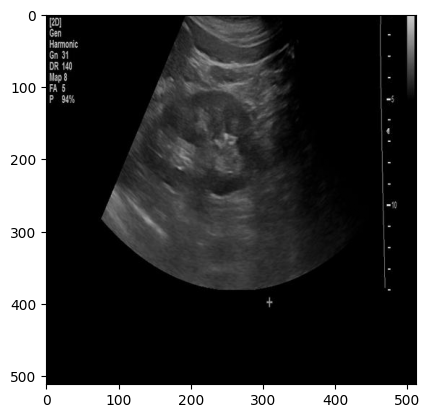

In [7]:
kid_image = cv2.imread(f'{dataset_path_stone}/Stone_5.JPG', cv2.IMREAD_GRAYSCALE)
plt.imshow(kid_image, cmap='gray')

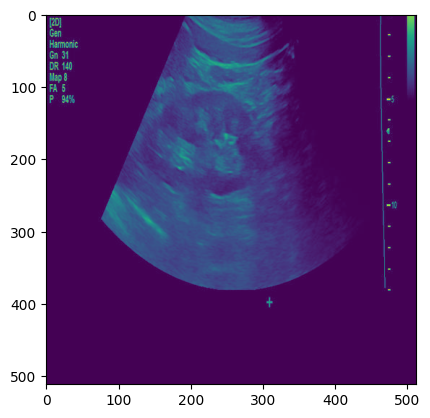

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
kid_image_scaled = transform_img(kid_image)
colored_kid = cm.viridis(kid_image_scaled)
plt.imshow(colored_kid)

#### Load and preprocess images

In [9]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

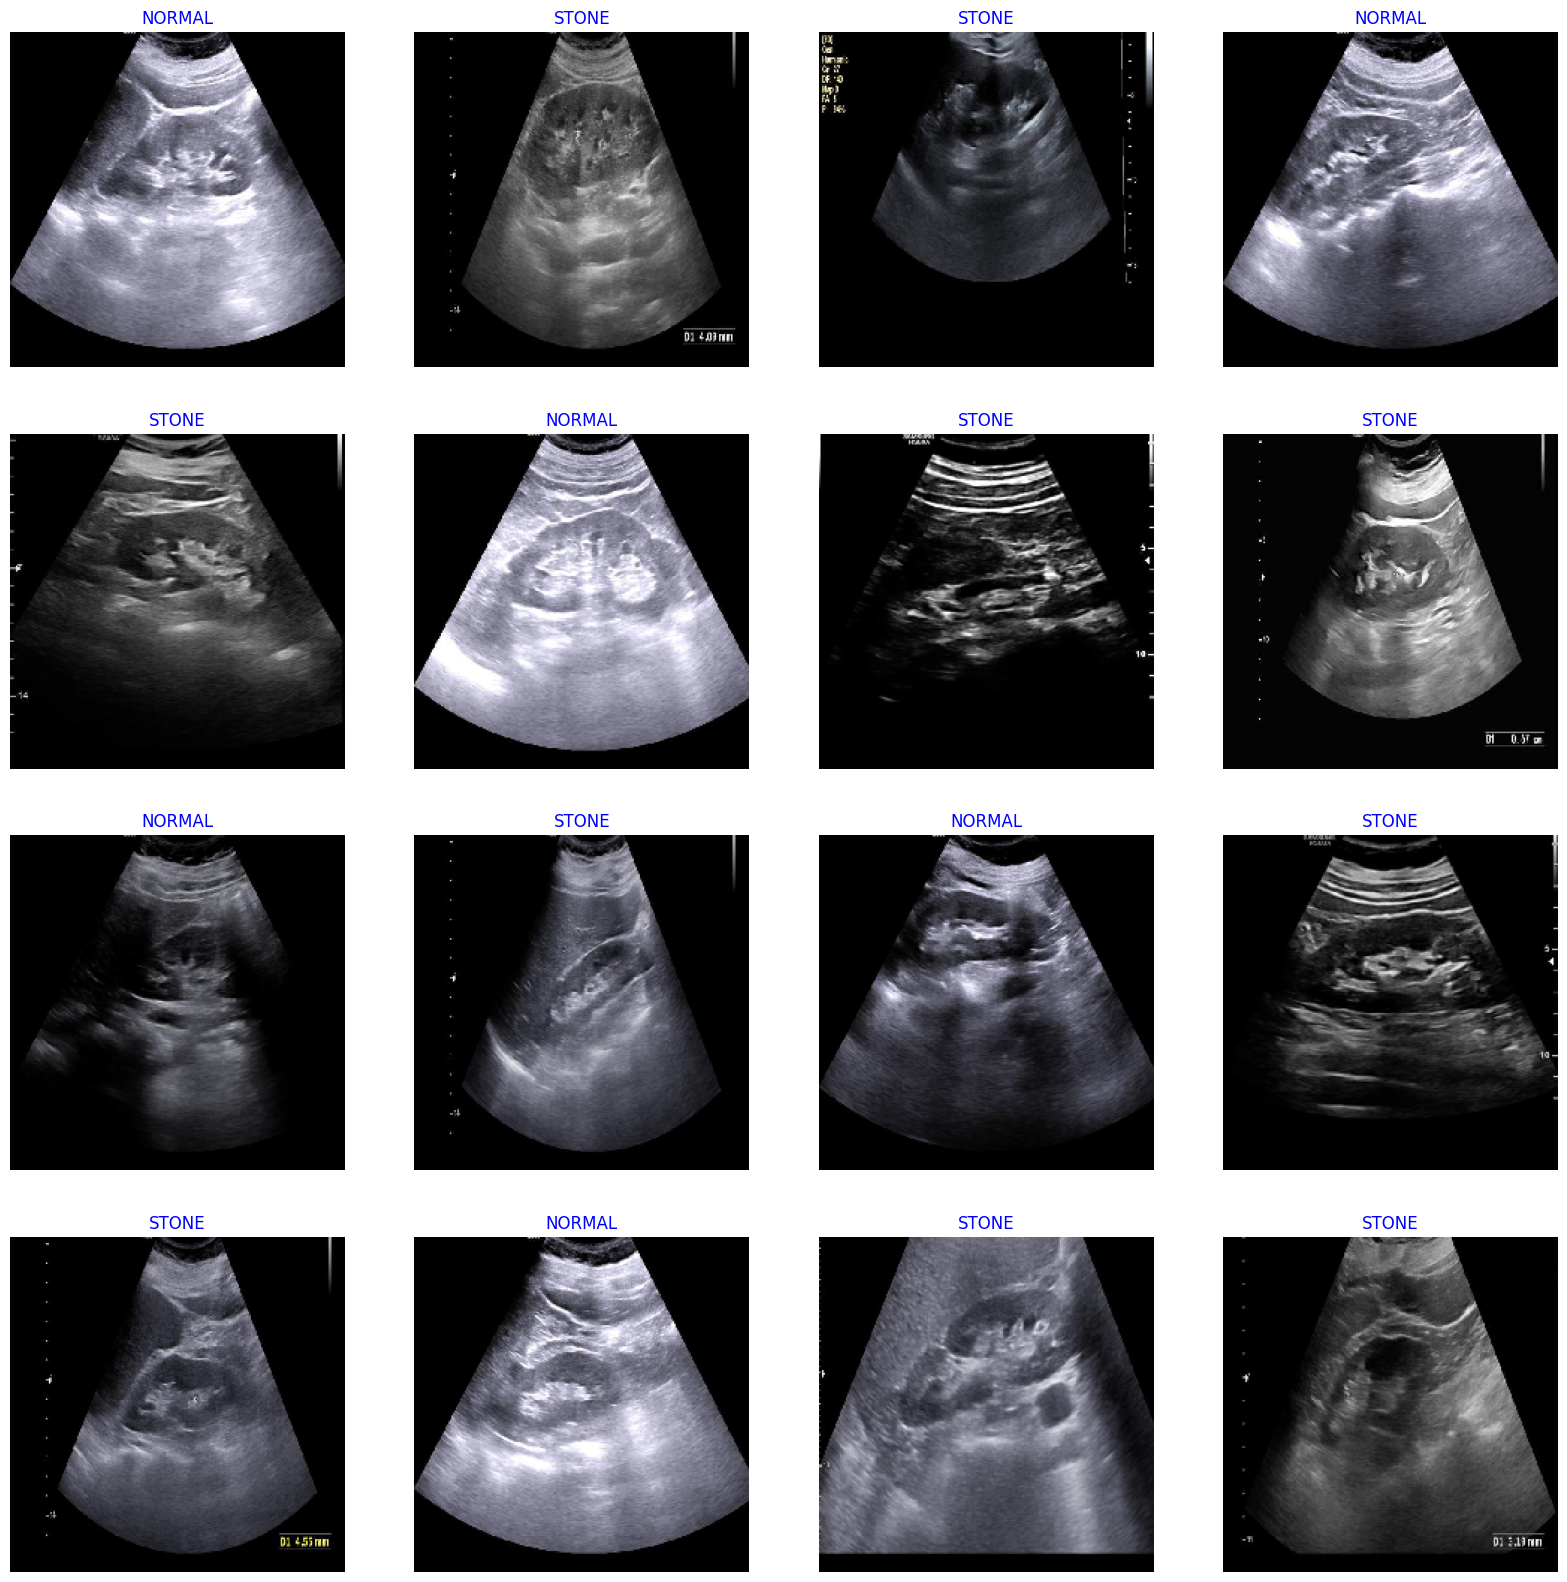

In [10]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_normal, 'NORMAL')
stone_filepaths, stone_labels = load_file_paths_and_labels(dataset_path_stone, 'STONE')

all_filepaths = stone_filepaths + normal_filepaths
all_labels = stone_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'NORMAL': 0, 'STONE': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [11]:
normal_data, normal_labels = load_and_limit_data(dataset_path_normal, label=0, num_samples=150)
stone_data, stone_labels = load_and_limit_data(dataset_path_stone, label=1, num_samples=300)

all_data = np.concatenate([normal_data, stone_data], axis=0)
all_labels = np.concatenate([normal_labels, stone_labels], axis=0)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

In [12]:
y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

#### Quantum layer

In [13]:
def create_qnn():
    num_qubits = 3
    feature_map = ZZFeatureMap(feature_dimension=num_qubits)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True
    )
    return qnn

#### Setting quantum model

In [14]:
class QuantumCNN(nn.Module):
    def __init__(self, quantum_layer):
        super(QuantumCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.quantum_layer = quantum_layer

        self.fc1 = None
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        quantum_input = torch.rand(x.size(0), 3)
        quantum_out = self.quantum_layer(quantum_input)
        x = torch.cat((x, quantum_out), dim=1)
        if self.fc1 is None:
            input_size = x.shape[1]
            self.fc1 = nn.Linear(input_size, 512).to(x.device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Initialize the model

In [15]:
num_qubits = 3
quantum_layer = TorchConnector(create_qnn())
quantum_model = QuantumCNN(quantum_layer)

#### Initialize criterion, optimizer

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.001)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_train_tensor = torch.argmax(torch.tensor(y_train, dtype=torch.float32), dim=1)

#### Training function

In [17]:
def fit_quantum_model(model, X_train, y_train, epochs=20, batch_size=32):
    model.train()
    history = {'loss': [], 'accuracy': []}

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()
            y_batch = torch.argmax(y_batch, dim=1)

            y_batch = y_batch.long()

            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1) 
            acc = (predicted == y_batch).float().mean().item()
            epoch_accuracy += acc

        avg_epoch_loss = epoch_loss / len(data_loader)
        avg_epoch_accuracy = epoch_accuracy / len(data_loader)
        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    return history

In [18]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=10)

Epoch [1/10], Loss: 0.4979, Accuracy: 0.8151
Epoch [2/10], Loss: 0.1585, Accuracy: 0.9557
Epoch [3/10], Loss: 0.0708, Accuracy: 0.9740
Epoch [4/10], Loss: 0.0209, Accuracy: 0.9974
Epoch [5/10], Loss: 0.0097, Accuracy: 1.0000
Epoch [6/10], Loss: 0.0022, Accuracy: 1.0000
Epoch [7/10], Loss: 0.0012, Accuracy: 1.0000
Epoch [8/10], Loss: 0.0006, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0003, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0002, Accuracy: 1.0000


#### Plotting accuracy and loss

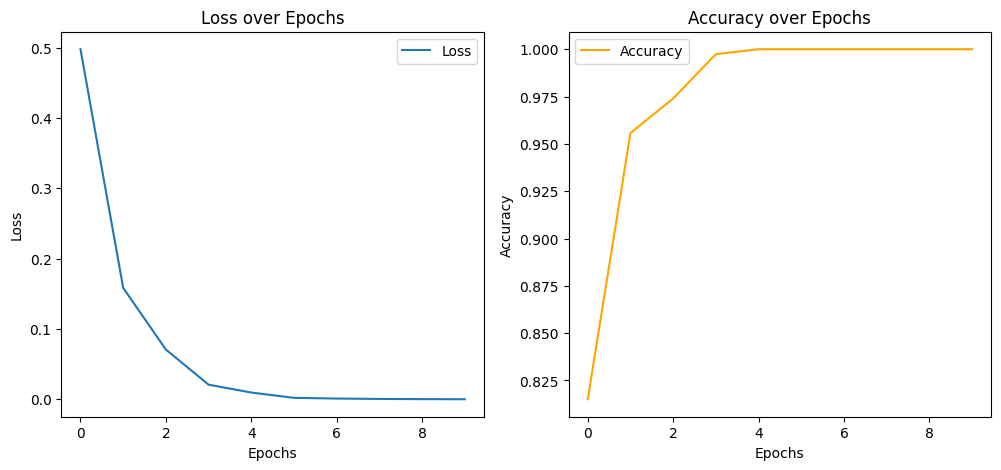

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Evaluate performance

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

quantum_model.to(device)

y_train_indices = torch.tensor(y_train, dtype=torch.long).to(device) 
y_test_indices = torch.tensor(y_test, dtype=torch.long).to(device)

quantum_model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

with torch.no_grad():
    outputs = quantum_model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

    if len(y_test_indices.shape) > 1:
        y_test_labels = torch.argmax(y_test_indices, dim=1).cpu().numpy()
    else:
        y_test_labels = y_test_indices.cpu().numpy()

print(f"Test Accuracy: {metrics.accuracy_score(y_test_labels, y_pred) * 100:.2f}%")
print(metrics.classification_report(y_test_labels, y_pred, target_names=['Normal', 'Stone']))

Test Accuracy: 100.00%
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        35
       Stone       1.00      1.00      1.00        55

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



#### Compute evaluation metrics

In [21]:
if y_pred.ndim == 1:
    y_pred_labels = y_pred
else:
    y_pred_labels = torch.argmax(torch.tensor(y_pred), dim=1).numpy()

classification_rep = metrics.classification_report(y_test_labels, y_pred_labels, output_dict=True, zero_division=True)

conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)

roc_auc = metrics.roc_auc_score(y_test_labels, y_pred_labels)

print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report:
 {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 55.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 90.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 90.0}}
Confusion Matrix:
 [[35  0]
 [ 0 55]]
ROC AUC Score: 1.0


#### Predicted probability for Positive Class

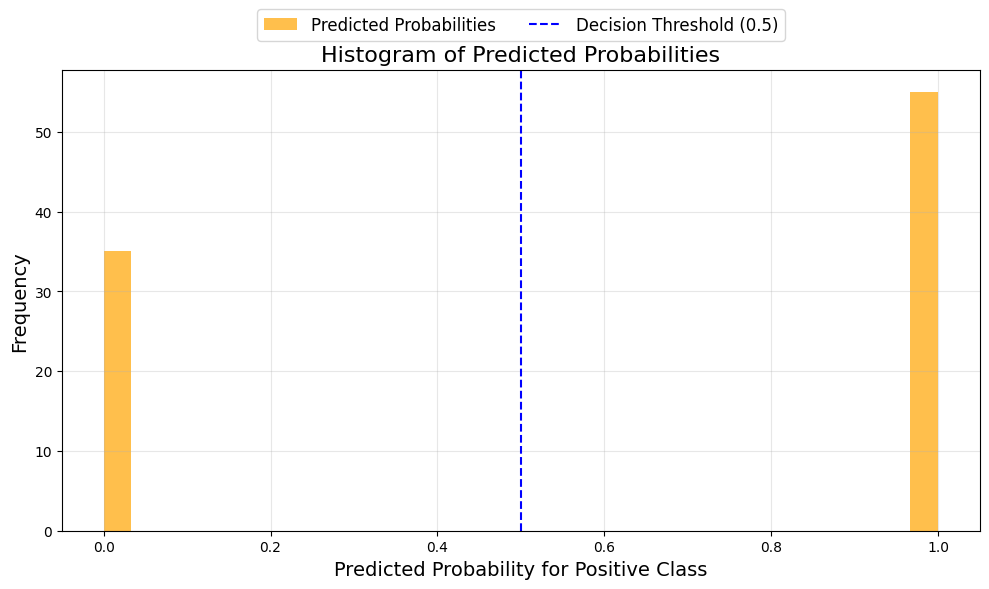

In [22]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

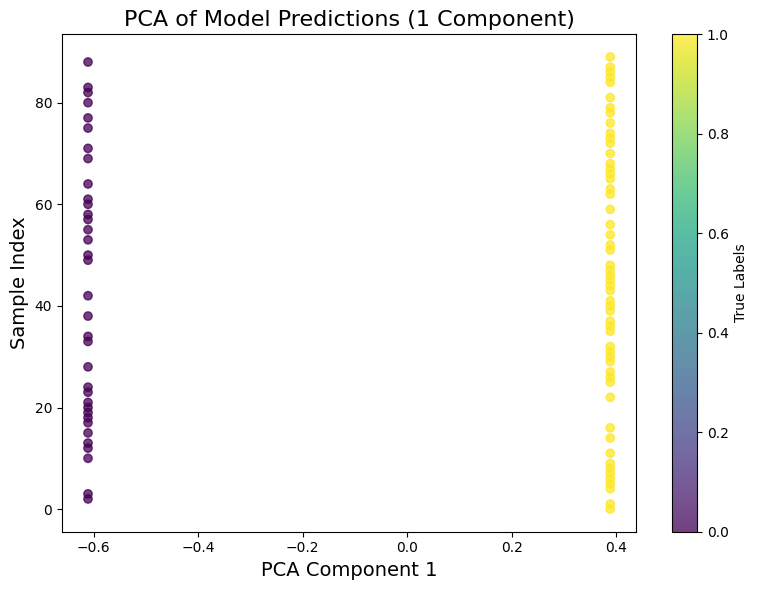

In [23]:
labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

##### Plot the confusion matrix

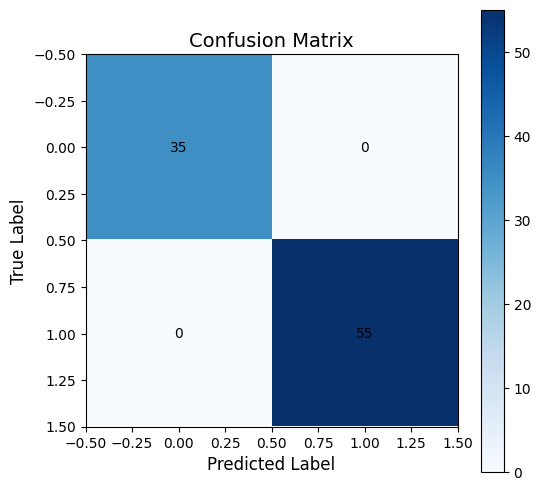

In [24]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

In [25]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright